In [91]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from scipy.cluster.hierarchy import linkage, dendrogram


In [92]:
df = pd.read_csv('data.csv')
print("Dataset Shape:", df.shape)
df.head()

Dataset Shape: (1000, 13)


,Alcohol,Malic_Acid,Ash,Ash_Alcanity,Magnesium,Total_Phenols,Flavanoids,Nonflavanoid_Phenols,Proanthocyanins,Color_Intensity,Hue,OD280,Proline
0,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
2,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
3,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
4,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735


In [93]:
X = df.values
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

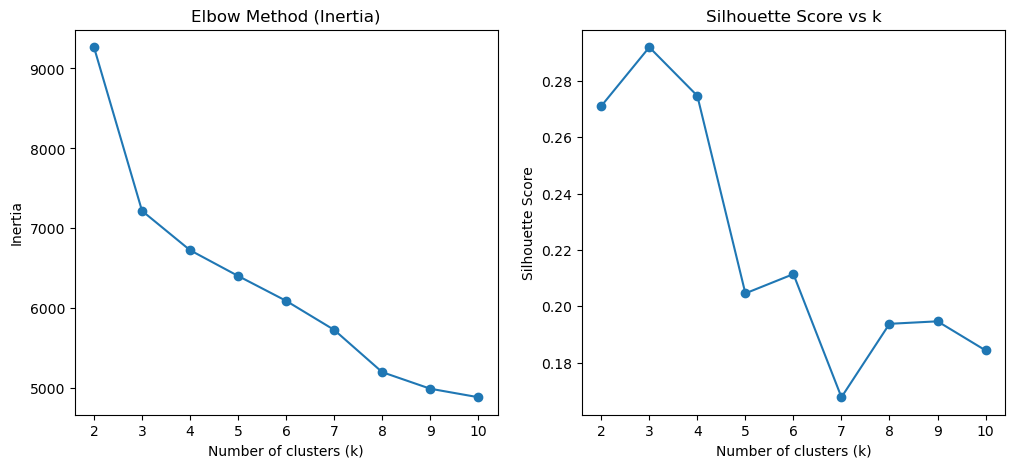

In [94]:
inertias = []
silhouette_scores = []
K = range(2, 11)

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(X_scaled)
    inertias.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(X_scaled, labels))

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

axes[0].plot(K, inertias, marker='o')
axes[0].set_title("Elbow Method (Inertia)")
axes[0].set_xlabel("Number of clusters (k)")
axes[0].set_ylabel("Inertia")

axes[1].plot(K, silhouette_scores, marker='o')
axes[1].set_title("Silhouette Score vs k")
axes[1].set_xlabel("Number of clusters (k)")
axes[1].set_ylabel("Silhouette Score")

plt.show()


In [95]:
results = []

kmeans = KMeans(n_clusters=3, random_state=42)
labels = kmeans.fit_predict(X_scaled)
results.append({
    "Algorithm": f"KMeans (k=3)",
    "Clusters": len(set(labels)),
    "Silhouette": silhouette_score(X_scaled, labels),
    "Davies-Bouldin": davies_bouldin_score(X_scaled, labels),
    "Calinski-Harabasz": calinski_harabasz_score(X_scaled, labels)
})

hier = AgglomerativeClustering(n_clusters=3)
labels = hier.fit_predict(X_scaled)
results.append({
    "Algorithm": f"Hierarchical (k=3)",
    "Clusters": len(set(labels)),
    "Silhouette": silhouette_score(X_scaled, labels),
    "Davies-Bouldin": davies_bouldin_score(X_scaled, labels),
    "Calinski-Harabasz": calinski_harabasz_score(X_scaled, labels)
})

dbscan = DBSCAN(eps=0.3, min_samples=5)
labels = dbscan.fit_predict(X_scaled)
n_clusters = len(set(labels)) - (1 if -1 in labels else 0)

if n_clusters > 1:
    results.append({
        "Algorithm": f"DBSCAN (eps=0.3)",
        "Clusters": n_clusters,
        "Silhouette": silhouette_score(X_scaled, labels),
        "Davies-Bouldin": davies_bouldin_score(X_scaled, labels),
        "Calinski-Harabasz": calinski_harabasz_score(X_scaled, labels)
    })
else:
    results.append({
        "Algorithm": f"DBSCAN (eps=0.3)",
        "Clusters": n_clusters,
        "Silhouette": np.nan,
        "Davies-Bouldin": np.nan,
        "Calinski-Harabasz": np.nan
    })

results_df = pd.DataFrame(results)
print(results_df)


            Algorithm  Clusters  Silhouette  Davies-Bouldin  Calinski-Harabasz
0        KMeans (k=3)         3    0.291961        1.395815         399.219974
1  Hierarchical (k=3)         3    0.288760        1.384761         392.656661
2    DBSCAN (eps=0.3)       117    0.679583        1.058758          31.149124


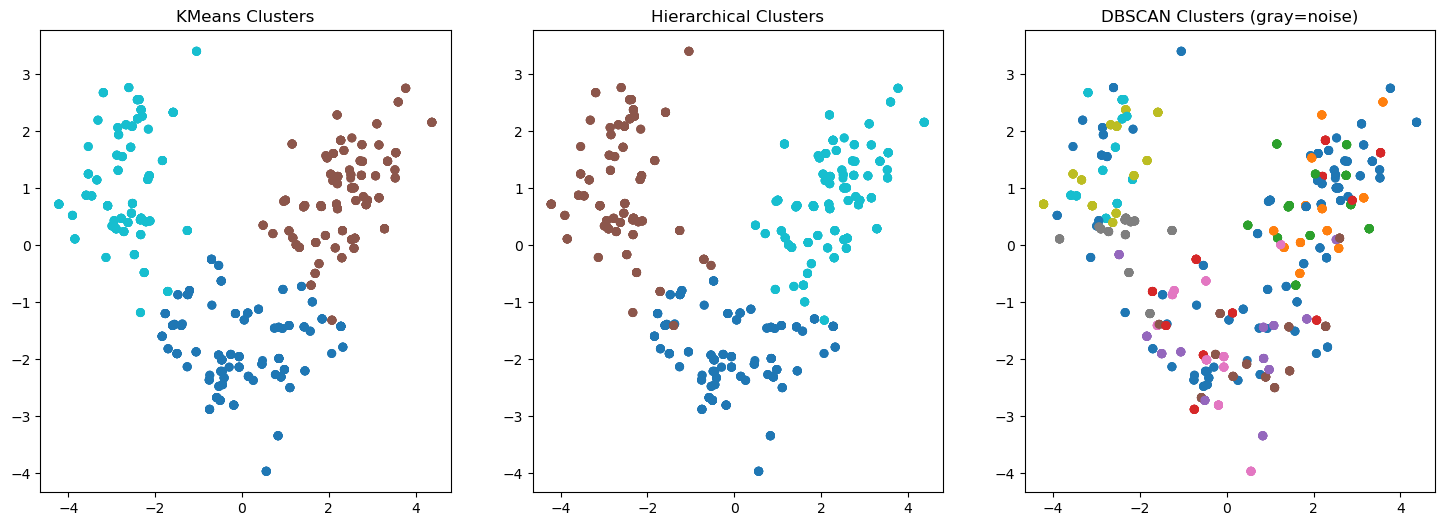

In [96]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

fig, axes = plt.subplots(1, 3, figsize=(18, 6))

axes[0].scatter(X_pca[:, 0], X_pca[:, 1], c=kmeans.labels_, cmap="tab10", s=30)
axes[0].set_title("KMeans Clusters")

axes[1].scatter(X_pca[:, 0], X_pca[:, 1], c=hier.labels_, cmap="tab10", s=30)
axes[1].set_title("Hierarchical Clusters")

labels_db = dbscan.labels_

axes[2].scatter(X_pca[:, 0], X_pca[:, 1],
                c=np.where(labels_db == -1, -1, labels_db),
                cmap="tab10", s=30)
axes[2].set_title("DBSCAN Clusters (gray=noise)")

plt.show()


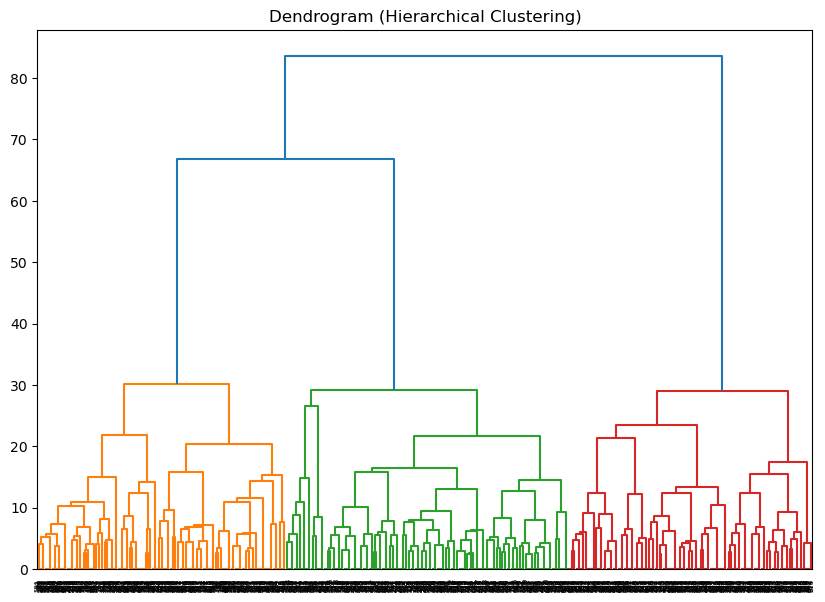

In [97]:
plt.figure(figsize=(10, 7))
linked = linkage(X_scaled, method='ward')
dendrogram(linked, orientation='top', distance_sort='descending', show_leaf_counts=True)
plt.title("Dendrogram (Hierarchical Clustering)")
plt.show()

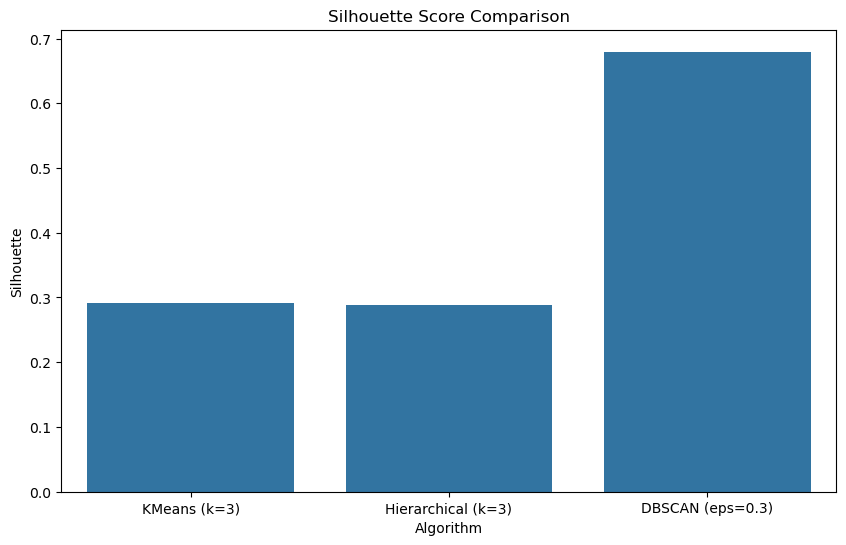

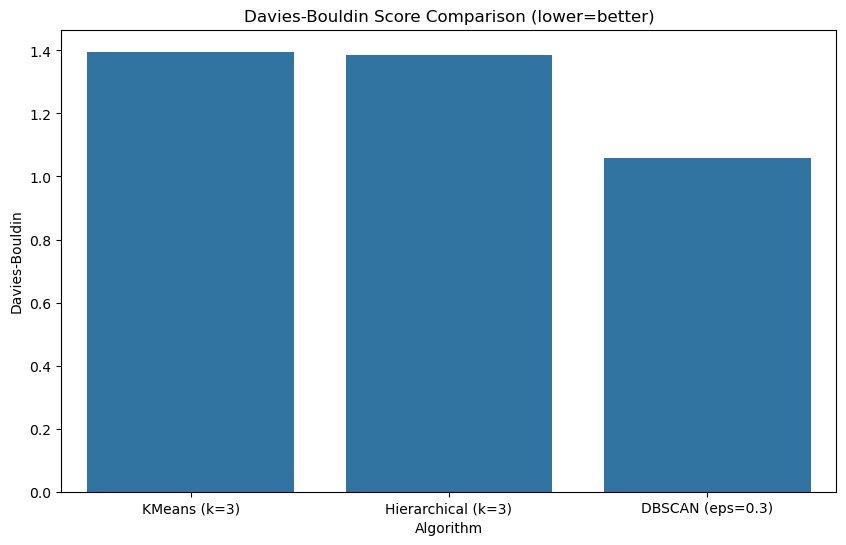

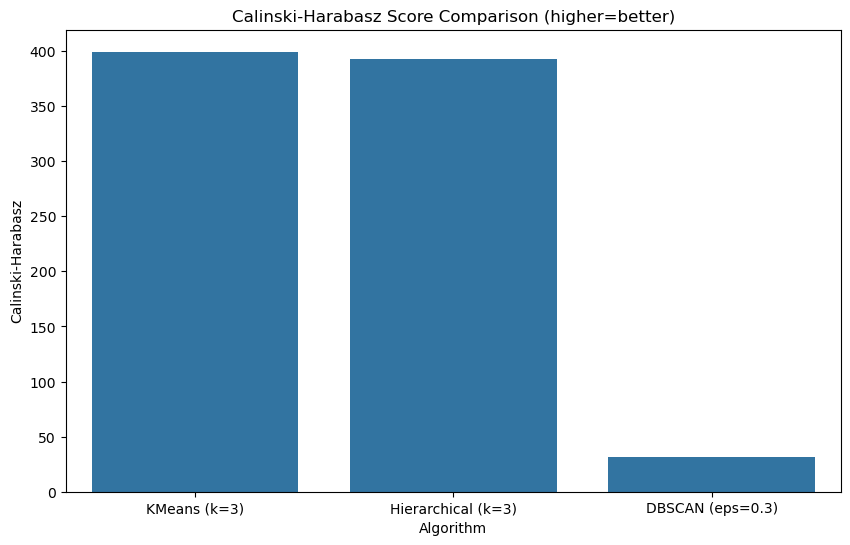

In [98]:
plt.figure(figsize=(10, 6))
sns.barplot(x="Algorithm", y="Silhouette", data=results_df)
plt.title("Silhouette Score Comparison")
plt.show()

plt.figure(figsize=(10, 6))
sns.barplot(x="Algorithm", y="Davies-Bouldin", data=results_df)
plt.title("Davies-Bouldin Score Comparison (lower=better)")
plt.show()

plt.figure(figsize=(10, 6))
sns.barplot(x="Algorithm", y="Calinski-Harabasz", data=results_df)
plt.title("Calinski-Harabasz Score Comparison (higher=better)")
plt.show()


In [99]:
best_k = 3
best_score = -1
results_tuning = []

for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(X_scaled)
    sil_score = silhouette_score(X_scaled, labels)
    db_score = davies_bouldin_score(X_scaled, labels)
    ch_score = calinski_harabasz_score(X_scaled, labels)
    
    results_tuning.append({
        'k': k,
        'Silhouette': sil_score,
        'Davies-Bouldin': db_score,
        'Calinski-Harabasz': ch_score
    })
    
    if sil_score > best_score:
        best_score = sil_score
        best_k = k

tuning_df = pd.DataFrame(results_tuning)
print(tuning_df)

print(f"Best k based on Silhouette score: {best_k}")

    k  Silhouette  Davies-Bouldin  Calinski-Harabasz
0   2    0.270962        1.503489         402.945620
1   3    0.294346        1.396700         400.464109
2   4    0.262639        1.685647         320.344333
3   5    0.220070        1.813116         267.327500
4   6    0.227004        1.766622         243.527934
5   7    0.182383        1.810251         216.161092
6   8    0.193797        1.663099         212.399282
7   9    0.194680        1.627797         198.498708
8  10    0.188009        1.655648         183.998689
Best k based on Silhouette score: 3


    Alcohol  Malic_Acid       Ash  Ash_Alcanity  Magnesium  Total_Phenols  \
0 -0.954903   -0.384774 -0.363321      0.301680  -0.558279       0.014238   
1  0.152711    0.857136  0.183918      0.502157  -0.063828      -0.959803   
2  0.834232   -0.349713  0.208947     -0.738041   0.619720       0.813015   

   Flavanoids  Nonflavanoid_Phenols  Proanthocyanins  Color_Intensity  \
0    0.111724              0.078999         0.002439        -0.891897   
1   -1.171881              0.604978        -0.748496         0.909403   
2    0.897234             -0.601440         0.642788         0.118181   

        Hue     OD280   Proline  
0  0.440708  0.313094 -0.761285  
1 -1.148159 -1.261505 -0.439220  
2  0.544019  0.770812  1.148673  


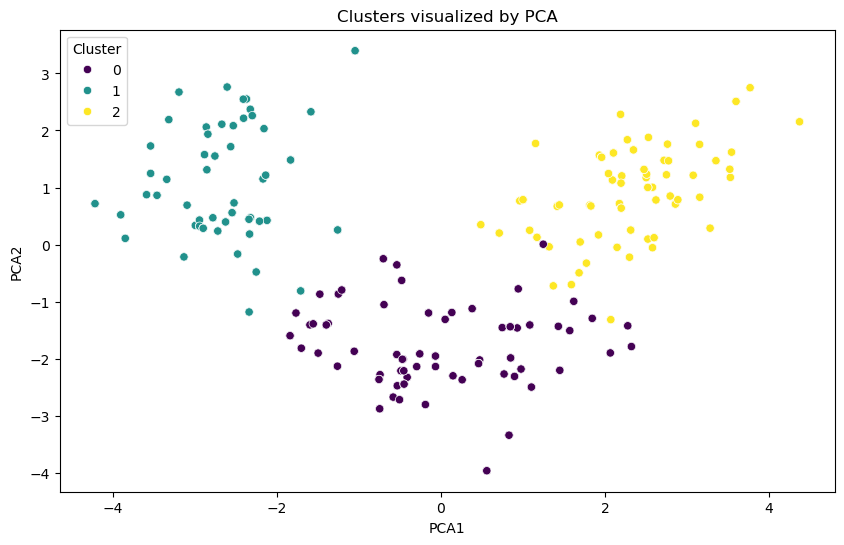

In [100]:
final_kmeans = KMeans(n_clusters=best_k, random_state=42, n_init=10)
final_labels = final_kmeans.fit_predict(X_scaled)

df['Cluster'] = final_labels

cluster_centers = pd.DataFrame(final_kmeans.cluster_centers_, columns=df.columns[:-1])
print(cluster_centers)

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)
df['PCA1'] = X_pca[:, 0]
df['PCA2'] = X_pca[:, 1]

plt.figure(figsize=(10, 6))
sns.scatterplot(x='PCA1', y='PCA2', hue='Cluster', data=df, palette='viridis')
plt.title('Clusters visualized by PCA')
plt.show()